In [1]:
#Importamos las bibiotecas requeridas
from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import re
import seaborn as sns

In [2]:
#Lectura del csv
df = pd.read_csv('properatti.csv')

In [3]:
#Solo nos quedamos con las operaciones en dólares
df = df.loc[ df.currency.isin(['USD']), : ]

In [4]:
#Imputación de price_usd_per_m2 tomando el valor de price_per_m2 si el primero es null y el segundo no..
df.loc[ df.price_usd_per_m2.isnull() & ~df.price_per_m2.isnull() , ['price_usd_per_m2'] ] = df.price_per_m2

In [5]:
#Regex para extraer el número de rooms en una determinada columna
def regex_rooms(row,column):
    
    pattern = "(?P<key>( \d| \d\d))( (amb |ambientes))"
    regex = re.compile(pattern)
    try:
        return regex.search(row[column].lower()).group('key')
    except:
        return 0

In [6]:
#Definición de una nueva columna con el resultado de aplicar regex en description
df['description_rooms'] = df.apply(lambda x: regex_rooms(x,'description'), axis = 1)

In [7]:
#Asignación del valor para rooms siempre y cuando sea nulo y por otro lado tengamos un valor en description por medio de Regex
df.loc[ df.rooms.isna() & df.description_rooms != 0, ['rooms'] ] = df['description_rooms']

In [8]:
#Definición de una nueva columna con el resultado de aplicar regex en title
df['title_rooms'] = df.apply(lambda x: regex_rooms(x,'title'), axis = 1)

In [9]:
#Asignación del valor para rooms siempre y cuando sea nulo y por otro lado tengamos un valor en title por medio de Regex
df.loc[ df.rooms.isna() & df.title_rooms != 0, ['rooms'] ] = df['title_rooms']

In [10]:
#Establecemos en cero aquellos casos donde no pudimos asignar un valor a rooms para luego transformarlo en entero
df.loc[ df.rooms.isna() , ['rooms'] ] = 0
df['rooms'] = df['rooms'].astype(int)

In [11]:
#Seleccionamos los registros y columnas de interes 
df_ = df.loc[ (df.state_name.isin(['Capital Federal'])) & (df.rooms >= 1) & (df.rooms <= 6) & (df.surface_covered_in_m2 > 0) & (df.surface_covered_in_m2 < 100) , ['place_name','rooms','price_usd_per_m2','surface_covered_in_m2','price_aprox_usd'] ].reset_index(drop=True)

In [12]:
#Visualización de los primeros registros
df_.head()

,place_name,rooms,price_usd_per_m2,surface_covered_in_m2,price_aprox_usd
0,Palermo Soho,1,2234.000000,30.0,111700.0
1,Palermo Soho,1,3521.428571,31.0,147900.0
2,Mataderos,4,1707.142857,98.0,239000.0
3,Palermo,3,3365.384615,96.0,350000.0
4,Palermo,4,2292.372881,73.0,270500.0


In [13]:
#Cantidad de filas y columnas
df_.shape

(15125, 5)

In [14]:
#Info de las columnas
df_.describe()

,rooms,price_usd_per_m2,surface_covered_in_m2,price_aprox_usd
count,15125.000000,1.512500e+04,15125.000000,1.512500e+04
mean,2.343471,3.943750e+03,52.036099,1.760270e+05
std,1.002400,2.395423e+04,19.241574,1.625976e+05
min,1.000000,7.051282e+01,1.000000,5.500000e+03
25%,2.000000,2.037037e+03,37.000000,9.800000e+04
50%,2.000000,2.463768e+03,48.000000,1.350000e+05
75%,3.000000,3.028125e+03,66.000000,1.940000e+05
max,6.000000,2.600000e+06,99.000000,6.809000e+06


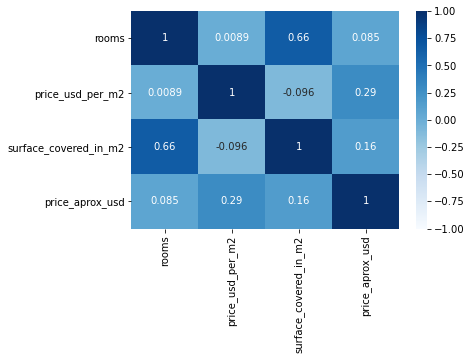

In [15]:
#Correlación entre columnas
sns.heatmap(df_.corr(), annot=True, vmin=-1, cmap='Blues');

In [16]:
#Definición de una nueva columna por cada una de las variables categoricas en place_name
dummy = pd.get_dummies(df_['place_name'],drop_first=True)
dummy.head()

,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Capital Federal,...,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#Concatenamos las columnas del paso anterior
df_ = pd.concat([df_,dummy],axis=1)

In [18]:
#Visualización de columnas
df_.columns

Index(['place_name', 'rooms', 'price_usd_per_m2', 'surface_covered_in_m2',
       'price_aprox_usd', 'Agronomía', 'Almagro', 'Balvanera', 'Barracas',
       'Barrio Norte', 'Belgrano', 'Boca', 'Boedo', 'Caballito',
       'Capital Federal', 'Centro / Microcentro', 'Chacarita', 'Coghlan',
       'Colegiales', 'Congreso', 'Constitución', 'Flores', 'Floresta',
       'Las Cañitas', 'Liniers', 'Mataderos', 'Monserrat', 'Monte Castro',
       'Nuñez', 'Once', 'Palermo', 'Palermo Chico', 'Palermo Hollywood',
       'Palermo Soho', 'Palermo Viejo', 'Parque Avellaneda',
       'Parque Centenario', 'Parque Chacabuco', 'Parque Chas',
       'Parque Patricios', 'Paternal', 'Pompeya', 'Puerto Madero', 'Recoleta',
       'Retiro', 'Saavedra', 'San Cristobal', 'San Nicolás', 'San Telmo',
       'Tribunales', 'Velez Sarsfield', 'Versalles', 'Villa Crespo',
       'Villa Devoto', 'Villa General Mitre', 'Villa Lugano', 'Villa Luro',
       'Villa Ortuzar', 'Villa Pueyrredón', 'Villa Real', 'Villa Riach

In [19]:
#Visualización de columnas (Cantidad)
df_.columns.value_counts().sum()

65

In [20]:
#Seleccionamos una clase de modelo
model = LinearRegression()

In [21]:
#Seleccionamos una matriz de features y un vector target
X = df_.drop(['place_name','price_aprox_usd'], axis = 1)
y = df_[['price_aprox_usd']]

In [22]:
#Separamos el dataset entre training y test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

In [23]:
#Ajustamos el modelo a los datos de entrenamiento
model.fit(Xtrain, ytrain)

LinearRegression()

In [24]:
#Predicción con los datos de test
ypred = model.predict(Xtest)

In [25]:
#Visualización de las métricas de performance
print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(2))

MAE: 55435.5
MSE: 13416107981.11
RMSE: 115827.92
R2: 0.34


In [26]:
#Definición de una única escala para los datos
scaler =  StandardScaler()
X_train_scaled = scaler.fit_transform(Xtrain)
X_test_scaled  = scaler.transform(Xtest)

In [27]:
#Definición de los alphas, lasso, parámetros y errores
alphas = np.logspace(0,7,20)

error_train_lista = []
error_test_lista = []

params = pd.DataFrame()

for alpha in alphas:
    
    lasso = Lasso(alpha = alpha, max_iter = 10000)
    lasso.fit(X_train_scaled, ytrain.values)
    params = pd.concat([params,pd.DataFrame({f'{alpha}':lasso.coef_},index = X.columns)], axis = 1)
    
    error_train = mean_squared_error(ytrain, lasso.predict(X_train_scaled))
    error_test  = mean_squared_error(ytest,  lasso.predict(scaler.transform(X_test_scaled)))
    
    error_train_lista.append(error_train)
    error_test_lista.append(error_test)

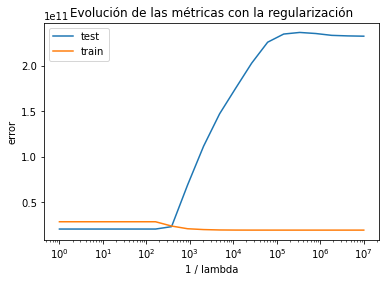

In [28]:
#Evolución de las métricas con la regularización
plt.plot(alphas[::-1], error_test_lista, label = 'test')
plt.plot(alphas[::-1], error_train_lista, label = 'train')

plt.title('Evolución de las métricas con la regularización')
plt.legend()
plt.xlabel('1 / lambda')
plt.ylabel('error')
plt.xscale('log')
plt.show()

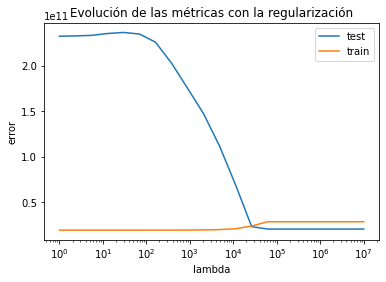

In [29]:
#Evolución de las métricas con la regularización
plt.plot(alphas, error_test_lista, label = 'test')
plt.plot(alphas, error_train_lista, label = 'train')

plt.title('Evolución de las métricas con la regularización')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('error')
plt.xscale('log')
plt.show()

In [30]:
#Visualización de los coefientes para la columna Puerto Madero según avanza la regularización
params.loc[ 'Puerto Madero' ,  : ]

1.0                   20705.610969
2.3357214690901222    20627.368282
5.455594781168519     20476.029271
12.742749857031335    20086.805218
29.76351441631318     19690.300560
69.51927961775606     19305.866587
162.3776739188721     18906.442959
379.26901907322497    18631.982601
885.8667904100823     17954.042042
2069.138081114788     16725.821133
4832.930238571752     13850.406807
11288.378916846883     7818.643261
26366.508987303554        0.000000
61584.82110660255         0.000000
143844.9888287663         0.000000
335981.8286283781         0.000000
784759.9703514606         0.000000
1832980.7108324338        0.000000
4281332.398719387         0.000000
10000000.0                0.000000
Name: Puerto Madero, dtype: float64

In [31]:
#Filtramos los parámetros con el valor 11288.378916846883
df_params_11288 = pd.DataFrame({'place_name':params['11288.378916846883'].index, 'value':params['11288.378916846883'].values})
df_params_11288 = df_params_11288.loc[ df_params_11288['value'] > 0 , :].reset_index(drop=True).sort_values(['value'], ascending=[False])
df_params_11288


,place_name,value
2,Boedo,41068.834504
0,price_usd_per_m2,35809.997999
5,San Cristobal,33209.304785
1,surface_covered_in_m2,28426.884674
4,Puerto Madero,7818.643261
3,Palermo,729.331971


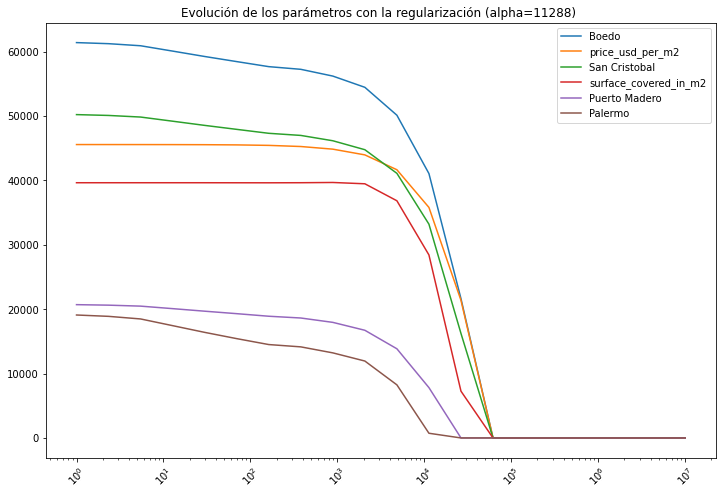

In [32]:
#Visualización de como avanza la regularización
params_to_plot = params.loc[ pd.Index(df_params_11288['place_name'].tolist()) , : ]
alphas_to_plot = params_to_plot.columns
alphas_to_plot = np.array(alphas_to_plot, dtype = 'float')

plt.figure(figsize=(12, 8))

for i in range(0,len(params_to_plot)):
    plt.plot(alphas_to_plot, np.abs(params_to_plot.iloc[i].values), label = params_to_plot.index[i])

plt.title('Evolución de los parámetros con la regularización (alpha=11288) ')
plt.legend()
plt.xticks(rotation = 45)
plt.xscale('log')
plt.show()

In [33]:
#Visualización de los coefientes para la columna Puerto Madero según avanza la regularización
params.loc[ 'Puerto Madero' ,  : ]

1.0                   20705.610969
2.3357214690901222    20627.368282
5.455594781168519     20476.029271
12.742749857031335    20086.805218
29.76351441631318     19690.300560
69.51927961775606     19305.866587
162.3776739188721     18906.442959
379.26901907322497    18631.982601
885.8667904100823     17954.042042
2069.138081114788     16725.821133
4832.930238571752     13850.406807
11288.378916846883     7818.643261
26366.508987303554        0.000000
61584.82110660255         0.000000
143844.9888287663         0.000000
335981.8286283781         0.000000
784759.9703514606         0.000000
1832980.7108324338        0.000000
4281332.398719387         0.000000
10000000.0                0.000000
Name: Puerto Madero, dtype: float64

In [34]:
#Filtramos los parámetros con el valor 4832.930238571752
df_params_4832 = pd.DataFrame({'place_name':params['4832.930238571752'].index, 'value':params['4832.930238571752'].values})
df_params_4832 = df_params_4832.loc[ df_params_4832.value > 0 , :].reset_index(drop=True).sort_values(['value'], ascending=[False])
df_params_4832


,place_name,value
4,Boedo,50131.196042
0,price_usd_per_m2,41662.763474
11,San Cristobal,41103.204548
1,surface_covered_in_m2,36842.594325
9,Puerto Madero,13850.406807
6,Palermo,8246.968089
3,Belgrano,3670.595243
10,Recoleta,2839.741255
7,Palermo Chico,2473.895226
8,Palermo Hollywood,996.604755


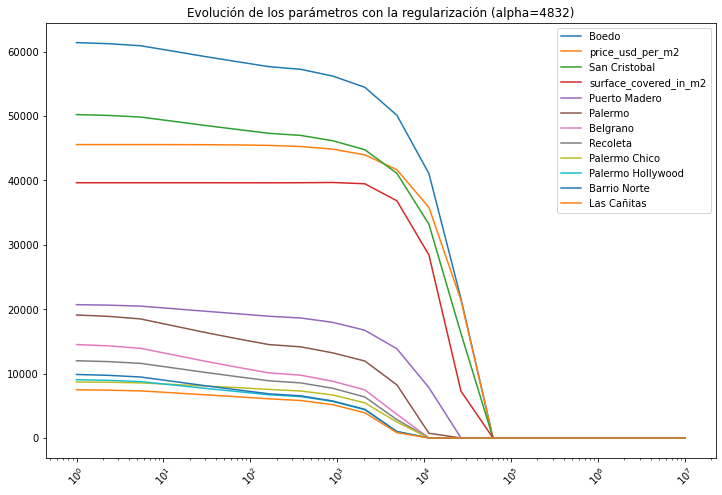

In [35]:
#Visualización de como avanza la regularización
params_to_plot = params.loc[ pd.Index(df_params_4832['place_name'].tolist()) , : ]
alphas_to_plot = params_to_plot.columns
alphas_to_plot = np.array(alphas_to_plot, dtype = 'float')

plt.figure(figsize=(12, 8))

for i in range(0,len(params_to_plot)):
    plt.plot(alphas_to_plot, np.abs(params_to_plot.iloc[i].values), label = params_to_plot.index[i])

plt.title('Evolución de los parámetros con la regularización (alpha=4832)')
plt.legend()
plt.xticks(rotation = 45)
plt.xscale('log')
plt.show()

In [36]:
#Mejor alpha
mejor_alpha = np.argmin(error_test_lista)
mejor_alpha = alphas[mejor_alpha]
print(mejor_alpha)

61584.82110660255


In [37]:
#Mejor lasso tomando el mejor alpha
#mejor_lasso = Lasso(alpha = mejor_alpha)

In [38]:
#Mejor lasso tomando el valor 11288.378916846883
mejor_lasso = Lasso(alpha = 11288.378916846883)

In [39]:
#Ajustamos el modelo a los datos de entrenamiento
mejor_lasso.fit(X_train_scaled, ytrain.values)

Lasso(alpha=11288.378916846883)

In [40]:
#Visualización de las columnas que mantenemos luego de regularizar con alpha = 11288.378916846883
X.columns[mejor_lasso.coef_ != 0]

Index(['price_usd_per_m2', 'surface_covered_in_m2', 'Boedo', 'Palermo',
       'Puerto Madero', 'San Cristobal'],
      dtype='object')

In [41]:
#Visualización de alpha y scores para lasso cv
model_lasso_cv = linear_model.LassoCV(alphas = alphas, fit_intercept=True, normalize=False, cv=10, max_iter=1e4)
model_fit_lasso_cv = model_lasso_cv.fit(Xtrain, ytrain)
print(model_fit_lasso_cv.alpha_)
print(model_fit_lasso_cv.score(Xtrain, ytrain))

C:\Users\Franco\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


162.3776739188721
0.31976231826032553


In [42]:
#Visualización de los coeficientes para lasso cv
best_alpha = model_fit_lasso_cv.alpha_
model_lasso = linear_model.Lasso(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_lasso = model_lasso.fit(Xtrain, ytrain)
print(model_fit_lasso.coef_)
print(model_fit_lasso.intercept_)
print(model_fit_lasso.score(Xtrain, ytrain))
print(model_fit_lasso.score(Xtest, ytest))

[ 2.85753347e+03  1.68094762e+00  2.13097433e+03 -0.00000000e+00
  4.74836313e+03 -2.20227800e+04 -1.44583227e+03  3.68177561e+04
  3.90729189e+04 -0.00000000e+00  2.66449636e+05  5.79995412e+03
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  1.37487531e+03 -0.00000000e+00 -2.17783247e+04 -1.67800326e+04
 -2.85839756e+04  5.56747892e+04 -7.64776160e+03 -6.61002092e+03
 -1.37843945e+04 -0.00000000e+00  3.13570580e+04 -1.18280858e+04
  5.36851366e+04  8.43005038e+04  4.43673543e+04  3.43408463e+04
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -1.00138337e+04 -0.00000000e+00 -0.00000000e+00
  1.74242757e+05  4.67237021e+04  0.00000000e+00  8.08642624e+03
  2.80518530e+05 -0.00000000e+00 -5.33076460e+02 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -4.22320788e+04  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  5.84030

In [43]:
#Visualización de alpha y scores para ridge cv
model_ridge_cv = linear_model.RidgeCV(alphas = alphas, fit_intercept=True, normalize=False, cv=10)
model_fit_ridge_cv = model_ridge_cv.fit(Xtrain, ytrain)
print(model_fit_ridge_cv.alpha_)
print(model_fit_ridge_cv.best_score_)

5.455594781168519
-0.18091864354739334


In [44]:
#Visualización de los coeficientes para ridge cv
best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_ridge = model_ridge.fit(Xtrain, ytrain)
print(model_fit_ridge.coef_)
print(model_fit_ridge.intercept_)
print(model_fit_ridge.score(Xtrain, ytrain))
print(model_fit_ridge.score(Xtest, ytest))

[[ 4.22931049e+03  1.67454212e+00  2.08038507e+03 -8.76840589e+03
   4.33211681e+02 -3.60098681e+04 -2.01446827e+04  3.34999787e+04
   3.30434180e+04 -3.08700960e+04  2.59650871e+05 -4.82170806e+02
  -1.56038289e+04 -9.63149965e+03 -1.43017655e+04 -3.27103360e+03
   5.00369149e+03 -9.57840505e+03 -4.71434622e+04 -2.83609706e+04
  -4.54116165e+04  7.02949691e+04 -3.19075495e+04 -3.08670490e+04
  -3.05805824e+04 -2.32632411e+04  2.95227064e+04 -4.39862962e+04
   4.73398545e+04  1.06487175e+05  4.41002443e+04  3.85788789e+04
   4.24073164e+04 -5.04235210e+04 -1.09488074e+04 -2.16132454e+04
  -1.06929464e+04 -3.11462462e+04 -3.40252047e+04 -2.98514776e+04
   1.75056709e+05  4.31191717e+04 -6.57577691e+03  9.18686488e+03
   2.73535922e+05 -2.21276207e+04 -1.29370455e+04 -1.87481940e+04
  -1.59346381e+04 -2.19390778e+04 -5.91339329e+03 -5.31695802e+03
  -1.78314405e+04 -7.26381380e+04  1.35583951e+03 -6.08976505e+03
  -1.35736086e+04 -2.23764232e+04 -1.26196856e+04 -2.79709691e+04
  -6.98160